In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [2]:

import torch
import torch.backends.cudnn as cudnn
from torch.utils.data import Subset
import random
import numpy as np

from collections import defaultdict

# seeds
seed = 88
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
cudnn.deterministic = True
cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
g = torch.Generator()
g.manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [3]:
from torchvision.datasets import FGVCAircraft
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# remove copyright banner
class RemoveCopyrightBanner(object):
    def __call__(self, img):
        width, height = img.size
        return img.crop((0, 0, width, height - 20))

transform = transforms.Compose([
    RemoveCopyrightBanner(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## EDA on manufacturer annotation

In [4]:
# try loading manufacturer for annotation_level

def balance_train_val(trainval_dataset_full):
    TARGET_SAMPLES_PER_CLASS = 66

    print(f"Original trainval dataset size: {len(trainval_dataset_full)}")
    print(f"Number of manufacturers: {len(trainval_dataset_full.classes)}")

    # Group indices by manufacturer label
    print("\nGrouping indices by manufacturer...")
    manufacturer_indices = defaultdict(list)
    # Accessing internal attributes - use with understanding
    # _labels contains the integer index for the class of each sample
    for idx, label_index in enumerate(trainval_dataset_full._labels):
        manufacturer_indices[label_index].append(idx)

    # Print initial counts per class
    print("Original counts per manufacturer (showing first 10):")
    original_counts = {trainval_dataset_full.classes[lbl]: len(indices) for lbl, indices in manufacturer_indices.items()}
    for i, (manufacturer, count) in enumerate(original_counts.items()):
        if i < 10:
            print(f"- {manufacturer}: {count}")
        elif i == 10:
            print("...")
            break


    # Sample indices for each manufacturer
    print(f"\nSampling up to {TARGET_SAMPLES_PER_CLASS} indices per manufacturer...")
    balanced_indices = []
    total_sampled = 0
    for label_index, indices in manufacturer_indices.items():
        # Determine how many samples to take for this class
        num_samples = min(len(indices), TARGET_SAMPLES_PER_CLASS)
        # Randomly sample without replacement
        sampled_for_class = random.sample(indices, num_samples)
        balanced_indices.extend(sampled_for_class)
        total_sampled += num_samples

    print(f"Total indices sampled for balanced dataset: {len(balanced_indices)}")
    # Shuffle the final list of indices (optional but good practice)
    random.shuffle(balanced_indices)

    # Create a Subset using the balanced indices
    print("\nCreating balanced Subset...")
    balanced_trainval_dataset = Subset(trainval_dataset_full, balanced_indices)
    print(f"Balanced trainval dataset size: {len(balanced_trainval_dataset)}")

    train_dataset_manu, val_dataset_manu = torch.utils.data.random_split(balanced_trainval_dataset, [0.8, 0.2])
    return train_dataset_manu, val_dataset_manu


# trainval then split
trainval_dataset_manu = FGVCAircraft(
    root='./data',
    split='trainval',              # Options: 'train', 'val', 'trainval', 'test'
    annotation_level='manufacturer',    # Options: 'variant', 'family', 'manufacturer'
    transform=transform,
    download=True
)

train_dataset_manu, val_dataset_manu = balance_train_val(trainval_dataset_manu)
# original way without balancing
# train_dataset_manu, val_dataset_manu = torch.utils.data.random_split(trainval_dataset_manu, [0.8, 0.2])

test_dataset_manu = FGVCAircraft(
    root='./data',
    split='test',
    annotation_level='manufacturer',
    transform=transform,
    download=True
)

100%|██████████| 2.75G/2.75G [01:45<00:00, 26.0MB/s]


Original trainval dataset size: 6667
Number of manufacturers: 30

Grouping indices by manufacturer...
Original counts per manufacturer (showing first 10):
- Boeing: 1466
- Airbus: 867
- ATR: 133
- Antonov: 67
- British Aerospace: 267
- Beechcraft: 134
- Lockheed Corporation: 134
- Douglas Aircraft Company: 267
- Canadair: 267
- Cessna: 266
...

Sampling up to 66 indices per manufacturer...
Total indices sampled for balanced dataset: 1980

Creating balanced Subset...
Balanced trainval dataset size: 1980


In [5]:
import pandas as pd

# --- Function to convert dataset to DataFrame ---
def dataset_to_dataframe_manu(dataset: FGVCAircraft) -> pd.DataFrame:
    """Converts an FGVCAircraft dataset object into a Pandas DataFrame."""
    image_files = dataset._image_files  # List of full image paths
    labels = dataset._labels          # List of numerical label indices
    class_names = dataset.classes     # List of manufacturer names
    # print(class_names)

    # Map numerical labels to manufacturer names
    manufacturer_names = [class_names[label_idx] for label_idx in labels]

    df = pd.DataFrame({
        'image_path': image_files,
        'manufacturer_index': labels,
        'manufacturer_name': manufacturer_names
    })
    return df

def show_dataframe_info_manu(df):
    # --- Display basic info and head of the DataFrame ---
    # print("\nTrain DataFrame Info:")
    # df_train.info()
    print("\nDataFrame Head:")
    print(df.head())

    # --- Calculate and display the counts per manufacturer ---
    print("\nNumber of images per manufacturer in dataset:")
    manufacturer_counts_train = df['manufacturer_name'].value_counts()
    print(manufacturer_counts_train)

    # --- additional info ---
    print("\nNumber of manufacturer in dataset:")
    print(len(manufacturer_counts_train))
    print("\nNumber of data in dataset:")
    print(len(df))


# --- Function to convert Subset to DataFrame ---
def subset_to_dataframe(subset) -> pd.DataFrame:
    """Converts a torch.utils.data.Subset object (wrapping FGVCAircraft)
       into a Pandas DataFrame."""

    original_dataset = subset.dataset # Get the underlying FGVCAircraft dataset
    subset_indices = subset.indices   # Get the list of indices for this subset

    # Access data from the *original* dataset using the subset indices
    image_files = [original_dataset._image_files[i] for i in subset_indices]
    labels = [original_dataset._labels[i] for i in subset_indices]
    class_names = original_dataset.classes # Get class names from original dataset

    # Map numerical labels to manufacturer names
    manufacturer_names = [class_names[label_idx] for label_idx in labels]

    df = pd.DataFrame({
        'original_index': subset_indices, # Optional: Keep track of original index
        'image_path': image_files,
        'manufacturer_index': labels,
        'manufacturer_name': manufacturer_names
    })
    return df

def nested_subset_to_dataframe(subset_final: Subset) -> pd.DataFrame:
    """
    Converts a nested Subset (Subset of a Subset wrapping a base dataset like FGVCAircraft)
    into a Pandas DataFrame.
    """

    # --- Input Validation ---
    if not isinstance(subset_final, Subset):
        raise TypeError(f"Input must be a torch.utils.data.Subset, got {type(subset_final)}")

    # --- Access the intermediate Subset ---
    subset_intermediate = subset_final.dataset
    if not isinstance(subset_intermediate, Subset):
         print(f"Input Subset's dataset is not a Subset (nesting expected), got {type(subset_intermediate)}, calling subset_to_dataframe")
         return subset_to_dataframe(subset_final)

    # --- Access the original base dataset ---
    original_dataset = subset_intermediate.dataset
    # Add a check to ensure we reached a dataset with the expected attributes
    if not (hasattr(original_dataset, '_image_files') and
            hasattr(original_dataset, '_labels') and
            hasattr(original_dataset, 'classes')):
        raise TypeError(f"Base dataset (type: {type(original_dataset)}) doesn't have expected attributes "
                        "(_image_files, _labels, classes). Did nesting go wrong?")

    # --- Get the index lists ---
    indices_final = subset_final.indices         # Indices relative to subset_intermediate
    indices_intermediate = subset_intermediate.indices # Indices relative to original_dataset

    # --- Map final indices to original indices ---
    original_indices = [indices_intermediate[i] for i in indices_final]

    # --- Access data from the *original* dataset using the resolved original indices ---
    image_files = [original_dataset._image_files[orig_idx] for orig_idx in original_indices]
    labels = [original_dataset._labels[orig_idx] for orig_idx in original_indices]
    class_names = original_dataset.classes # Get class names from original dataset

    # Map numerical labels to manufacturer names
    manufacturer_names = [class_names[label_idx] for label_idx in labels]

    df = pd.DataFrame({
        'original_index': original_indices, # Index relative to the very original FGVCAircraft dataset
        'image_path': image_files,
        'manufacturer_index': labels,
        'manufacturer_name': manufacturer_names,
        # Optional: keep track of the index within the final subset if needed
        # 'final_subset_local_index': indices_final
    })
    return df


In [6]:
# --- Convert the train dataset to a DataFrame ---
print("\nConverting train dataset to DataFrame...")
# df_train_manu = subset_to_dataframe(train_dataset_manu)
df_train_manu = nested_subset_to_dataframe(train_dataset_manu)
print("Train DataFrame created.")

show_dataframe_info_manu(df_train_manu)
# df_train_manu.head(800)


Converting train dataset to DataFrame...
Train DataFrame created.

DataFrame Head:
   original_index                                         image_path  \
0            2380  ./data/fgvc-aircraft-2013b/data/images/1946038...   
1            3321  ./data/fgvc-aircraft-2013b/data/images/1581695...   
2            5150  ./data/fgvc-aircraft-2013b/data/images/0768399...   
3            6550  ./data/fgvc-aircraft-2013b/data/images/0960091...   
4            2833  ./data/fgvc-aircraft-2013b/data/images/0517837...   

   manufacturer_index         manufacturer_name  
0                  14               Eurofighter  
1                  28                  Yakovlev  
2                  12  Douglas Aircraft Company  
3                  22                   Panavia  
4                  19      Lockheed Corporation  

Number of images per manufacturer in dataset:
manufacturer_name
Cessna                      58
Fairchild                   57
Saab                        56
Antonov                  

In [7]:
# --- Convert the val dataset to a DataFrame ---
print("\nConverting val dataset to DataFrame...")
df_val_manu = nested_subset_to_dataframe(val_dataset_manu)
print("Train DataFrame created.")

show_dataframe_info_manu(df_val_manu)


Converting val dataset to DataFrame...
Train DataFrame created.

DataFrame Head:
   original_index                                         image_path  \
0            5969  ./data/fgvc-aircraft-2013b/data/images/1875301...   
1            5236  ./data/fgvc-aircraft-2013b/data/images/1376572...   
2            3219  ./data/fgvc-aircraft-2013b/data/images/2118956...   
3            2001  ./data/fgvc-aircraft-2013b/data/images/0167123...   
4            5417  ./data/fgvc-aircraft-2013b/data/images/2075500...   

   manufacturer_index     manufacturer_name  
0                   5  Bombardier Aerospace  
1                  29          de Havilland  
2                  22               Panavia  
3                  29          de Havilland  
4                  24                 Robin  

Number of images per manufacturer in dataset:
manufacturer_name
Panavia                     19
Eurofighter                 19
Embraer                     17
Beechcraft                  17
de Havilland        

In [8]:
# --- Convert the test dataset to a DataFrame ---
print("\nConverting test dataset to DataFrame...")
df_test_manu = dataset_to_dataframe_manu(test_dataset_manu)
print("Test DataFrame created.")

show_dataframe_info_manu(df_test_manu)


Converting test dataset to DataFrame...
Test DataFrame created.

DataFrame Head:
                                          image_path  manufacturer_index  \
0  ./data/fgvc-aircraft-2013b/data/images/1514522...                   4   
1  ./data/fgvc-aircraft-2013b/data/images/0747566...                   4   
2  ./data/fgvc-aircraft-2013b/data/images/1008575...                   4   
3  ./data/fgvc-aircraft-2013b/data/images/0717480...                   4   
4  ./data/fgvc-aircraft-2013b/data/images/0991569...                   4   

  manufacturer_name  
0            Boeing  
1            Boeing  
2            Boeing  
3            Boeing  
4            Boeing  

Number of images per manufacturer in dataset:
manufacturer_name
Boeing                      734
Airbus                      433
McDonnell Douglas           233
Embraer                     233
de Havilland                166
Cessna                      134
Canadair                    133
Douglas Aircraft Company    133
British 

In [9]:
# --- Convert the original trainval dataset to a DataFrame ---
print("\nConverting trainval dataset to DataFrame...")
df_trainval_manu = dataset_to_dataframe_manu(trainval_dataset_manu)
print("Test DataFrame created.")

show_dataframe_info_manu(df_trainval_manu)


Converting trainval dataset to DataFrame...
Test DataFrame created.

DataFrame Head:
                                          image_path  manufacturer_index  \
0  ./data/fgvc-aircraft-2013b/data/images/1025794...                   4   
1  ./data/fgvc-aircraft-2013b/data/images/1340192...                   4   
2  ./data/fgvc-aircraft-2013b/data/images/0056978...                   4   
3  ./data/fgvc-aircraft-2013b/data/images/0698580...                   4   
4  ./data/fgvc-aircraft-2013b/data/images/0450014...                   4   

  manufacturer_name  
0            Boeing  
1            Boeing  
2            Boeing  
3            Boeing  
4            Boeing  

Number of images per manufacturer in dataset:
manufacturer_name
Boeing                      1466
Airbus                       867
McDonnell Douglas            467
Embraer                      467
de Havilland                 334
British Aerospace            267
Canadair                     267
Douglas Aircraft Company     

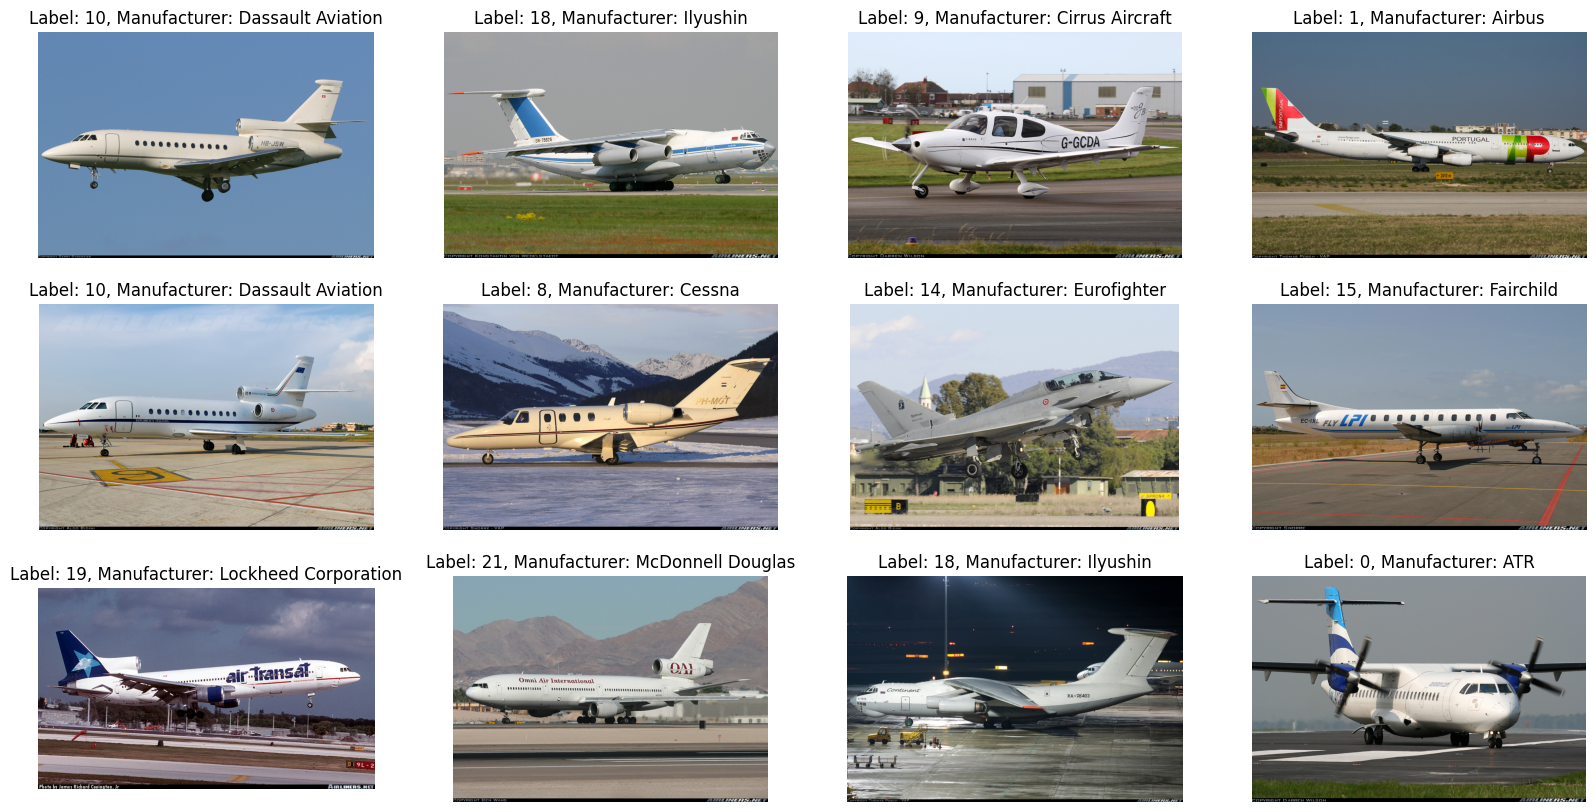

In [10]:
import random
from PIL import Image

# show various manufactuers
def show_images_manu(df, num_images_per_row=5, num_row=3):
    fig, axes = plt.subplots(num_row, num_images_per_row, figsize=(20, 10))
    for i in range(num_images_per_row * num_row):
        index_to_show = random.randint(0, len(df_train_manu) - 1)

        # Get the row corresponding to the chosen index
        image_row = df_train_manu.iloc[index_to_show]
        image_path = image_row['image_path']
        manufacturer_name = image_row['manufacturer_name']
        label = image_row['manufacturer_index']

        img = Image.open(image_path)

        r = i // num_images_per_row
        c = i% num_images_per_row

        # image = image.permute(1, 2, 0)  # convert from CxHxW to HxWxC
        axes[r, c].imshow(img)
        axes[r, c].set_title(f'Label: {label}, Manufacturer: {manufacturer_name}')
        axes[r, c].axis('off')
    plt.show()

show_images_manu(df_train_manu, num_images_per_row=4)

# Create Dataset

In [11]:
TASKS_TOTAL = 3
CLASS_PER_TASKS = 10

In [12]:
from collections import defaultdict
import torch
from tqdm import tqdm

def group_task_indices(dataset, cumulative=False):
    """
    Task 0: 0-9, Task 1: 10-19, ..., Task 9: 90-99
    Output a dictionary where keys are task indices and values are lists of image indices.
    For example, task_dict[0] will contain indices of images with labels 0-9.
    """
    task_dict = defaultdict(list)
    for idx, (_, label) in tqdm(enumerate(dataset), total=len(dataset)):
        # for test and val, should have cumulative indices (all classes seen so far)
        if cumulative:
          for i in range((label // CLASS_PER_TASKS), TASKS_TOTAL):
            task_dict[i].append(idx)
        else:
          task_dict[label // CLASS_PER_TASKS].append(idx)
    return task_dict

# train_task_idxs = group_task_indices(train_dataset)
# val_task_idxs = group_task_indices(val_dataset, cumulative=True)
# test_task_idxs = group_task_indices(test_dataset, cumulative=True)

train_task_idxs = group_task_indices(train_dataset_manu)
val_task_idxs = group_task_indices(val_dataset_manu, cumulative=True)
test_task_idxs = group_task_indices(test_dataset_manu, cumulative=True)

100%|██████████| 3333/3333 [00:45<00:00, 73.79it/s]


In [13]:
labels_dict = defaultdict(int)
for i in test_task_idxs[1]:
    _, label = test_dataset_manu[i]
    labels_dict[label] += 1
print(labels_dict)

defaultdict(<class 'int'>, {4: 734, 1: 433, 0: 67, 2: 33, 6: 133, 3: 66, 19: 66, 12: 133, 7: 133, 8: 134, 11: 33, 13: 233, 14: 34, 10: 67, 16: 100, 5: 33, 17: 67, 18: 34, 15: 34, 9: 34})


# EWC

In [14]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import random

class RobustEWC:
    def __init__(self, model, device='cuda', lambda_ewc=5000):
        """
        Initialize the Robust EWC class with a model and hyperparameters.

        Args:
            model: The neural network model
            device: Device to perform computations on ('cuda' or 'cpu')
            lambda_ewc: Regularization strength for EWC penalty
        """
        self.model = model
        self.device = device
        self.lambda_ewc = lambda_ewc

        # Dictionary to store Fisher information for each task
        self.fisher_dict = {}
        # Dictionary to store optimal parameters for each task
        self.optpar_dict = {}
        # Dictionary to store output layer sizes for each task
        self.output_sizes = {}
        # Dictionary to track important parameters
        self.important_params = {}

    def compute_fisher(self, data_loader, samples=500):
        """
        Compute the diagonal Fisher Information Matrix with proper sampling and verification.

        Args:
            data_loader: DataLoader containing the task's data
            samples: Number of samples to use for Fisher computation

        Returns:
            Dictionary with parameter names as keys and Fisher values as values
        """
        fisher = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        self.model.eval()

        sample_loader = torch.utils.data.DataLoader(
            torch.utils.data.Subset(data_loader.dataset,
                                  torch.randperm(len(data_loader.dataset))[:samples].tolist()),
            batch_size=1, shuffle=True
        )

        for input_data, _ in sample_loader:
            input_data = input_data.to(self.device)
            output = self.model(input_data)
            probs = F.softmax(output, dim=1)

            num_classes = probs.size(1)
            for c in range(num_classes):
                self.model.zero_grad()
                class_prob = probs[0, c]
                log_class_prob = torch.log(class_prob)
                log_class_prob.backward(retain_graph=(c < num_classes-1))

                prob_value = class_prob.item()
                for n, p in self.model.named_parameters():
                    if p.grad is not None and p.requires_grad:
                        fisher[n] += prob_value * p.grad.data.pow(2) / samples

        return fisher

    def store_task_parameters(self, task_id, data_loader):
        """
        Store the optimal parameters and compute Fisher after training on a task.

        Args:
            task_id: ID of the current task
            data_loader: DataLoader for the current task
        """
        print(f"Storing parameters for task {task_id}...")

        # Store current parameter values
        self.optpar_dict[task_id] = {}
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                self.optpar_dict[task_id][n] = p.data.clone()
                # Debug: Print parameter statistics for key layers
                if 'fc' in n or 'layer4' in n:
                    print(f"Stored parameter {n}: min={p.min().item():.6f}, max={p.max().item():.6f}, mean={p.mean().item():.6f}")

        # Compute and store Fisher Information Matrix
        self.fisher_dict[task_id] = self.compute_fisher(data_loader)

        # Store output layer size for this task
        if hasattr(self.model, 'fc'):
            self.output_sizes[task_id] = self.model.fc.weight.size(0)
            print(f"Stored output size for task {task_id}: {self.output_sizes[task_id]}")
        elif hasattr(self.model, 'classifier'):
            self.output_sizes[task_id] = self.model.classifier.weight.size(0)
            print(f"Stored output size for task {task_id}: {self.output_sizes[task_id]}")

    def ewc_loss(self, current_task_id):
        """
        Calculate the EWC penalty with importance scaling and verification.

        Args:
            current_task_id: ID of the current task

        Returns:
            EWC penalty loss
        """
        if current_task_id == 0:
            return torch.tensor(0.0, device=self.device)

        total_loss = 0
        param_count = 0

        # Calculate EWC loss for all previous tasks
        for task_id in range(current_task_id):
            task_loss = 0

            for n, p in self.model.named_parameters():
                if p.requires_grad and n in self.fisher_dict[task_id] and n in self.optpar_dict[task_id]:
                    # Handle expanding output layer
                    if "fc.weight" in n:
                        prev_size = self.output_sizes[task_id]
                        fisher_term = self.fisher_dict[task_id][n][:prev_size, :]
                        param_diff = (p[:prev_size, :] - self.optpar_dict[task_id][n][:prev_size, :]).pow(2)
                        task_loss += (fisher_term * param_diff).sum()
                        param_count += fisher_term.numel()
                    elif "fc.bias" in n:
                        prev_size = self.output_sizes[task_id]
                        fisher_term = self.fisher_dict[task_id][n][:prev_size]
                        param_diff = (p[:prev_size] - self.optpar_dict[task_id][n][:prev_size]).pow(2)
                        task_loss += (fisher_term * param_diff).sum()
                        param_count += fisher_term.numel()
                    else:
                        fisher_term = self.fisher_dict[task_id][n]
                        param_diff = (p - self.optpar_dict[task_id][n]).pow(2)
                        task_loss += (fisher_term * param_diff).sum()
                        param_count += fisher_term.numel()

            total_loss += task_loss

        # Apply lambda scaling
        ewc_penalty = self.lambda_ewc * total_loss / 2

        # Verify EWC penalty is significant enough (only in training mode to avoid spam)
        if self.model.training:
            with torch.no_grad():
                avg_penalty = ewc_penalty.item() / param_count if param_count > 0 else 0
                if avg_penalty < 1e-4:
                    print(f"WARNING: Average EWC penalty per parameter is very small: {avg_penalty:.8f}")

        return ewc_penalty

    def freeze_important_parameters(self, current_task_id, importance_threshold=0.1):
        """
        Freeze parameters that are most important for previous tasks.

        Args:
            current_task_id: ID of the current task
            importance_threshold: Threshold for determining important parameters
        """
        if current_task_id == 0:
            return

        # Calculate importance for each parameter based on Fisher
        importance = {}
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                importance[n] = 0
                for task_id in range(current_task_id):
                    if n in self.fisher_dict[task_id]:
                        # For expanding layers, only consider the relevant part
                        if "fc.weight" in n or "fc.bias" in n:
                            prev_size = self.output_sizes[task_id]
                            if "fc.weight" in n:
                                importance[n] += self.fisher_dict[task_id][n][:prev_size, :].mean().item()
                            else:  # fc.bias
                                importance[n] += self.fisher_dict[task_id][n][:prev_size].mean().item()
                        else:
                            importance[n] += self.fisher_dict[task_id][n].mean().item()

                # Average across tasks
                importance[n] /= current_task_id

        # Sort parameters by importance
        sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

        # Determine threshold value
        if importance_threshold < 1:  # Interpreted as a fraction
            threshold_idx = int(len(sorted_importance) * importance_threshold)
            threshold_value = sorted_importance[threshold_idx][1] if threshold_idx < len(sorted_importance) else 0
        else:  # Interpreted as an absolute value
            threshold_value = importance_threshold

        # Freeze important parameters
        frozen_count = 0
        self.important_params = {}
        for n, imp in sorted_importance:
            if imp > threshold_value:
                for name, param in self.model.named_parameters():
                    if name == n:
                        param.requires_grad = False
                        self.important_params[name] = imp
                        frozen_count += 1
                        break

        print(f"Froze {frozen_count} important parameters with importance > {threshold_value:.6f}")

    def consolidate_weights(self):
        """
        Consolidate weights after training on a task by averaging with previous optimal weights
        weighted by their importance.
        """
        if not self.optpar_dict:  # No previous tasks
            return

        print("Consolidating weights based on importance...")

        # Get the most recent task_id
        last_task_id = max(self.optpar_dict.keys())

        with torch.no_grad():
            for n, p in self.model.named_parameters():
                if n in self.important_params and n in self.optpar_dict[last_task_id]:
                    # Calculate importance-weighted average of current weights and previous optimal weights
                    importance = self.important_params[n]
                    if importance > 0.1:  # Only consolidate highly important parameters
                        weight_factor = min(0.8, importance)  # Cap at 0.8 to allow some adaptation
                        consolidated_weight = (
                            weight_factor * self.optpar_dict[last_task_id][n] +
                            (1 - weight_factor) * p.data
                        )
                        p.data.copy_(consolidated_weight)
                        print(f"Consolidated parameter {n} with weight factor {weight_factor:.4f}")


class MemoryBuffer:
    def __init__(self, capacity=200):
        """
        Initialize a memory buffer for storing samples from previous tasks.

        Args:
            capacity: Maximum number of samples to store
        """
        self.capacity = capacity
        self.buffer = []

    def add_samples(self, samples, labels, task_id):
        """
        Add samples to the memory buffer.

        Args:
            samples: Tensor of input samples
            labels: Tensor of corresponding labels
            task_id: ID of the task these samples belong to
        """
        for i in range(len(samples)):
            self.buffer.append((samples[i].clone(), labels[i].clone(), task_id))

            # If buffer exceeds capacity, remove random samples
            if len(self.buffer) > self.capacity:
                # Remove a random sample
                idx_to_remove = random.randint(0, len(self.buffer) - 1)
                self.buffer.pop(idx_to_remove)

    def get_batch(self, batch_size=32):
        """
        Get a random batch from the memory buffer.

        Args:
            batch_size: Number of samples to retrieve

        Returns:
            Tuple of (samples, labels, task_ids) or (None, None, None) if buffer is empty
        """
        if len(self.buffer) == 0:
            return None, None, None

        indices = random.sample(range(len(self.buffer)), min(batch_size, len(self.buffer)))
        samples = torch.stack([self.buffer[i][0] for i in indices])
        labels = torch.stack([self.buffer[i][1] for i in indices])
        task_ids = [self.buffer[i][2] for i in indices]

        return samples, labels, task_ids

    def get_task_samples(self, task_id, batch_size=32):
        """
        Get samples from a specific task.

        Args:
            task_id: ID of the task to retrieve samples from
            batch_size: Maximum number of samples to retrieve

        Returns:
            Tuple of (samples, labels) or (None, None) if no samples for the task
        """
        task_samples = [(s, l) for s, l, t in self.buffer if t == task_id]

        if not task_samples:
            return None, None

        # Sample randomly if we have more than batch_size
        if len(task_samples) > batch_size:
            task_samples = random.sample(task_samples, batch_size)

        samples = torch.stack([s for s, _ in task_samples])
        labels = torch.stack([l for _, l in task_samples])

        return samples, labels

## Training Code

In [15]:
def val_net(net_to_val, val_loader):
    net_to_val.eval()
    loss = 0

    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for img, label in tqdm(val_loader, desc="Validating"):

            # Get the input images and their corresponding labels
            img, label = img.cuda(), label.cuda()

            # Forward pass: Get predictions from the model
            outputs = net_to_val(img)

            # compute SmoothL1Losss
            loss += criterion(outputs, label)

        return loss / len(val_loader)

def train_net(max_epochs, freeze_epochs, patience, net_to_train, opt, train_loader, val_loader, task, save_file=None, save_path=None):
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    # prepare the net for training
    net_to_train.cuda()

    # freeze backbone
    for param in net_to_train.parameters():
        param.requires_grad = False
    for param in net_to_train.fc.parameters():
        param.requires_grad = True

    # loop over the dataset multiple times
    for epoch in range(max_epochs):
        net_to_train.train()

        running_loss = 0.0

        # unfreeze all layers
        if epoch == freeze_epochs:
          for param in net_to_train.parameters():
              param.requires_grad = True
              # change optimizer learning rate
              opt.param_groups[0]['lr'] = 1e-4

        # train on batches of data
        for imgs, labels in tqdm(train_loader, unit='batch'):

            imgs, labels = imgs.cuda(), labels.cuda()

            # zero the parameter gradients
            opt.zero_grad()

            # prediction
            outputs = net_to_train(imgs)

            # compute the loss
            loss = criterion(outputs, labels)
            loss.backward()
            opt.step()

            # print loss statistics
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        val_losses.append(val_net(net_to_train, val_loader))
        print(f"Epoch {epoch + 1}, Training Loss: {avg_loss:.3f}, Validation Loss: {val_losses[-1]:.3f}")

        # save to checkpoint
        if save_path:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': net_to_train.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': avg_loss,
            }, save_path)
            print(f"Checkpoint saved to {save_path}")

        # save task, trainloss, valloss to file
        if save_file:
            with open(save_file, 'a') as f:
                f.write(f"{task},{epoch + 1},{avg_loss},{val_losses[-1]}\n")

        # early stopping based on patience
        if len(val_losses) > patience and val_losses[-1] >= min(val_losses[:-patience]):
            print(f"Early stopping at epoch {epoch + 1}")
            break

    print("finished training")
    return train_losses, val_losses

In [16]:
def train_net_with_ewc_and_replay(max_epochs, freeze_epochs, net_to_train, opt, train_loader, val_loader,
                                 task_id, ewc, memory_buffer, save_file=None, save_path=None):
    criterion = torch.nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []

    # Prepare the net for training
    net_to_train.cuda()

    # Freeze backbone initially
    for param in net_to_train.parameters():
        param.requires_grad = False
    for param in net_to_train.fc.parameters():
        param.requires_grad = True

    # If not the first task, freeze important parameters
    if task_id > 0:
        ewc.freeze_important_parameters(task_id, importance_threshold=0.05)

    # Loop over the dataset multiple times
    for epoch in range(max_epochs):
        net_to_train.train()
        running_loss = 0.0
        running_task_loss = 0.0
        running_ewc_penalty = 0.0
        running_replay_loss = 0.0

        # Unfreeze all layers after freeze_epochs (except important ones)
        if epoch == freeze_epochs:
            for name, param in net_to_train.named_parameters():
                # Skip parameters already marked as important
                if not param.requires_grad and 'fc' not in name:
                    # Check if this parameter was frozen by importance
                    was_frozen_by_importance = False
                    for n, imp in getattr(ewc, 'important_params', {}).items():
                        if n == name:
                            was_frozen_by_importance = True
                            break

                    if not was_frozen_by_importance:
                        param.requires_grad = True

            # Change optimizer learning rate
            opt.param_groups[0]['lr'] = 1e-4

        # Train on batches of data
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}"):
            imgs, labels = imgs.cuda(), labels.cuda()

            # Zero the parameter gradients
            opt.zero_grad()

            # Forward pass
            outputs = net_to_train(imgs)

            # Compute the task loss
            task_loss = criterion(outputs, labels)

            # Compute the EWC penalty
            ewc_penalty = ewc.ewc_loss(task_id)

            # Initialize replay loss
            replay_loss = torch.tensor(0.0, device=imgs.device)

            # If not the first task, use memory replay
            if task_id > 0 and memory_buffer:
                replay_samples, replay_labels, _ = memory_buffer.get_batch(batch_size=min(32, len(imgs)))

                if replay_samples is not None:
                    replay_samples, replay_labels = replay_samples.cuda(), replay_labels.cuda()
                    replay_outputs = net_to_train(replay_samples)
                    replay_loss = criterion(replay_outputs, replay_labels)

            # Total loss = task loss + EWC penalty + replay loss
            loss = task_loss + ewc_penalty + replay_loss

            # Backward pass and optimize
            loss.backward()

            # Gradient clipping to prevent instability
            torch.nn.utils.clip_grad_norm_(net_to_train.parameters(), max_norm=1.0)

            opt.step()

            # Track losses separately
            running_task_loss += task_loss.item()
            running_ewc_penalty += ewc_penalty.item()
            running_replay_loss += replay_loss.item()
            running_loss += loss.item()

        # Store samples in memory buffer after each epoch
        if epoch == max_epochs - 1:  # Store samples from the last epoch
            for imgs, labels in train_loader:
                # Store a subset of samples
                indices = torch.randperm(len(imgs))[:min(10, len(imgs))]
                memory_buffer.add_samples(imgs[indices], labels[indices], task_id)

        # Calculate average losses
        avg_task_loss = running_task_loss / len(train_loader)
        avg_ewc_penalty = running_ewc_penalty / len(train_loader)
        avg_replay_loss = running_replay_loss / len(train_loader)
        avg_total_loss = running_loss / len(train_loader)

        train_losses.append(avg_total_loss)

        # Validate on current task
        current_val_loss = val_net(net_to_train, val_loader)
        val_losses.append(current_val_loss)

        # If we're on task 1+, also validate on task 0 to check forgetting
        task0_val_loss = None
        if task_id > 0 and 'task0_val_loader' in globals():
            task0_val_loss = val_net(net_to_train, task0_val_loader)
            print(f"Task 0 validation loss: {task0_val_loss:.4f}")

        print(f"Epoch {epoch+1}/{max_epochs}, Task Loss: {avg_task_loss:.4f}, "
              f"EWC Penalty: {avg_ewc_penalty:.4f}, Replay Loss: {avg_replay_loss:.4f}, "
              f"Total Loss: {avg_total_loss:.4f}, Validation Loss: {current_val_loss:.4f}")

        # Save checkpoint
        if save_path:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': net_to_train.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': avg_total_loss,
            }, save_path)

        # Save metrics to file
        if save_file:
            with open(save_file, 'a') as f:
                metrics = f"{task_id},{epoch+1},{avg_task_loss},{avg_ewc_penalty},{avg_replay_loss},{avg_total_loss},{current_val_loss}"
                if task0_val_loss is not None:
                    metrics += f",{task0_val_loss}"
                f.write(metrics + "\n")

    print("Finished training")
    return train_losses, val_losses


In [17]:
import torch.nn as nn
def modify_resnet_head(model, num_classes):
  """
  Modify the last fully connected layer of the ResNet model to match the number of classes.
  """

  old_fc = model.fc
  old_num_classes = old_fc.out_features
  num_ftrs = old_fc.in_features

  # Create the new head
  new_fc = nn.Linear(num_ftrs, num_classes).cuda()

  # Copy weights and biases from the old head
  if old_num_classes < num_classes:
    new_fc.weight.data[:old_num_classes, :] = old_fc.weight.data.clone().cuda()
    new_fc.bias.data[:old_num_classes] = old_fc.bias.data.clone().cuda()

  model.fc = new_fc
  return model

In [18]:
import torch

def get_test_accuracy(model, test_loader, num_classes):
    model.eval()
    correct_preds = 0
    total = 0
    correct_per_class = [0] * num_classes
    total_per_class = [0] * num_classes

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Testing", total=len(test_loader)):
            imgs, labels = imgs.cuda(), labels.cuda()
            output = model(imgs)
            preds = output.argmax(dim=1)

            correct_preds += (preds == labels).sum().item()
            total += labels.size(0)

            # Per-class stats
            for c in range(num_classes):
                correct_per_class[c] += ((preds == c) & (labels == c)).sum().item()
                total_per_class[c] += (labels == c).sum().item()

    overall_acc = correct_preds / total
    per_class_acc = [correct_per_class[c] / total_per_class[c] if total_per_class[c] > 0 else 0.0
                     for c in range(num_classes)]
    return overall_acc, per_class_acc


In [19]:
def evaluate_accuracy(model, data_loader):
    """Evaluate model accuracy on a dataset"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return correct / total

In [20]:
from torch.utils.data import Subset
from torchvision import models
import torch.optim as optim

# Initialize model
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)  # Start with 10 classes
model = model.cuda()

# Initialize EWC with higher lambda
ewc = RobustEWC(model, device='cuda', lambda_ewc=10e7)

# Initialize memory buffer
memory_buffer = MemoryBuffer(capacity=500)

# Create output directory
save_dir = 'run_robust_ewc'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Create output file for metrics
with open(os.path.join(save_dir, 'training_metrics.txt'), 'w') as f:
    f.write("Task,Epoch,TaskLoss,EWCPenalty,ReplayLoss,TotalLoss,CurrentValLoss,Task0ValLoss\n")

# Save task 0 validation loader for future reference
task0_val_loader = None

# Train on each task sequentially
for task_id in range(TASKS_TOTAL):
    print(f"\n{'='*50}\nTraining on task {task_id}\n{'='*50}")

    # Modify model head for the current task (expand by 10 classes)
    num_features = model.fc.in_features
    num_classes = (task_id + 1) * 10

    # Save the weights of the current fc layer before expanding
    if task_id > 0:
        old_weights = model.fc.weight.data.clone()
        old_bias = model.fc.bias.data.clone()

    # Replace with a new fc layer with more outputs
    model.fc = nn.Linear(num_features, num_classes)

    # If not the first task, copy the old weights to preserve knowledge
    if task_id > 0:
        with torch.no_grad():
            model.fc.weight.data[:old_weights.size(0)] = old_weights
            model.fc.bias.data[:old_bias.size(0)] = old_bias

    model = model.cuda()

    # Create optimizer with weight decay
    optimizer = optim.Adam(model.parameters(), lr=0.0015, weight_decay=1e-4)

    # Create data loaders for the current task
    train_loader = torch.utils.data.DataLoader(
        Subset(train_dataset_manu, train_task_idxs[task_id]),
        batch_size=64, shuffle=True,
        num_workers=4
    )

    val_loader = torch.utils.data.DataLoader(
        Subset(val_dataset_manu, val_task_idxs[task_id]),
        batch_size=64, shuffle=False,
        num_workers=4
    )

    test_loader = torch.utils.data.DataLoader(
        Subset(test_dataset_manu, test_task_idxs[task_id]), batch_size=32, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g
    )

    # Save task 0 validation loader
    if task_id == 0:
        task0_val_loader = val_loader

    # Train the model on the current task with EWC and replay
    train_losses, val_losses = train_net_with_ewc_and_replay(
        max_epochs=15,
        freeze_epochs=5,
        net_to_train=model,
        opt=optimizer,
        train_loader=train_loader,
        val_loader=val_loader,
        task_id=task_id,
        ewc=ewc,
        memory_buffer=memory_buffer,
        save_file=os.path.join(save_dir, 'training_metrics.txt'),
        save_path=os.path.join(save_dir, f'checkpoint_task_{task_id}.pth')
    )

    # After training, store parameters and compute Fisher for the current task
    ewc.store_task_parameters(task_id, train_loader)

    overall_acc, per_class_acc = get_test_accuracy(model, test_loader, (task_id+1) * 10)
    print(f"Overall accuracy for task {task_id}: {overall_acc:.4f}")
    print(f"Per-class accuracy for task {task_id}: {per_class_acc}")

    # Evaluate on all tasks seen so far
    for eval_task_id in range(task_id + 1):
        eval_loader = torch.utils.data.DataLoader(
            Subset(test_dataset_manu, test_task_idxs[eval_task_id]),
            batch_size=64, shuffle=False,
            num_workers=4
        )

        # Evaluate accuracy
        accuracy = evaluate_accuracy(model, eval_loader)
        print(f"Accuracy on task {eval_task_id} after training on task {task_id}: {accuracy:.4f}")

        # Save accuracy results
        with open(os.path.join(save_dir, 'accuracies.txt'), 'a') as f:
            f.write(f"{task_id},{eval_task_id},{accuracy:.4f}\n")

    # Save the model after training on each task
    torch.save(model.state_dict(), os.path.join(save_dir, f"model_task_{task_id}.pth"))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current 


Training on task 0


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


Epoch 1/15, Task Loss: 2.3841, EWC Penalty: 0.0000, Replay Loss: 0.0000, Total Loss: 2.3841, Validation Loss: 2.1975


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Epoch 2/15, Task Loss: 2.0372, EWC Penalty: 0.0000, Replay Loss: 0.0000, Total Loss: 2.0372, Validation Loss: 1.9763


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


Epoch 3/15, Task Loss: 1.7633, EWC Penalty: 0.0000, Replay Loss: 0.0000, Total Loss: 1.7633, Validation Loss: 1.8761


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


Epoch 4/15, Task Loss: 1.5397, EWC Penalty: 0.0000, Replay Loss: 0.0000, Total Loss: 1.5397, Validation Loss: 1.7032


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Epoch 5/15, Task Loss: 1.3581, EWC Penalty: 0.0000, Replay Loss: 0.0000, Total Loss: 1.3581, Validation Loss: 1.6382


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Epoch 6/15, Task Loss: 1.0875, EWC Penalty: 0.0000, Replay Loss: 0.0000, Total Loss: 1.0875, Validation Loss: 1.0931


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Epoch 7/15, Task Loss: 0.2899, EWC Penalty: 0.0000, Replay Loss: 0.0000, Total Loss: 0.2899, Validation Loss: 0.8478


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Epoch 8/15, Task Loss: 0.0676, EWC Penalty: 0.0000, Replay Loss: 0.0000, Total Loss: 0.0676, Validation Loss: 0.7872


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Epoch 9/15, Task Loss: 0.0159, EWC Penalty: 0.0000, Replay Loss: 0.0000, Total Loss: 0.0159, Validation Loss: 0.7673


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Epoch 10/15, Task Loss: 0.0084, EWC Penalty: 0.0000, Replay Loss: 0.0000, Total Loss: 0.0084, Validation Loss: 0.7130


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Epoch 11/15, Task Loss: 0.0048, EWC Penalty: 0.0000, Replay Loss: 0.0000, Total Loss: 0.0048, Validation Loss: 0.6945


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Epoch 12/15, Task Loss: 0.0035, EWC Penalty: 0.0000, Replay Loss: 0.0000, Total Loss: 0.0035, Validation Loss: 0.6839


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Epoch 13/15, Task Loss: 0.0025, EWC Penalty: 0.0000, Replay Loss: 0.0000, Total Loss: 0.0025, Validation Loss: 0.6829


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


Epoch 14/15, Task Loss: 0.0024, EWC Penalty: 0.0000, Replay Loss: 0.0000, Total Loss: 0.0024, Validation Loss: 0.6818


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


Epoch 15/15, Task Loss: 0.0026, EWC Penalty: 0.0000, Replay Loss: 0.0000, Total Loss: 0.0026, Validation Loss: 0.6827
Finished training
Storing parameters for task 0...
Stored parameter layer4.0.conv1.weight: min=-0.263336, max=0.382146, mean=-0.001549
Stored parameter layer4.0.bn1.weight: min=0.135523, max=0.428016, mean=0.264142
Stored parameter layer4.0.bn1.bias: min=-0.476384, max=0.144994, mean=-0.225544
Stored parameter layer4.0.conv2.weight: min=-0.283643, max=0.347602, mean=-0.001280
Stored parameter layer4.0.bn2.weight: min=0.142099, max=0.728998, mean=0.424145
Stored parameter layer4.0.bn2.bias: min=-0.399324, max=0.114041, mean=-0.197196
Stored parameter layer4.0.downsample.0.weight: min=-0.625400, max=0.747276, mean=-0.000818
Stored parameter layer4.0.downsample.1.weight: min=-0.052868, max=0.509644, mean=0.250051
Stored parameter layer4.0.downsample.1.bias: min=-0.399324, max=0.114041, mean=-0.197196
Stored parameter layer4.1.conv1.weight: min=-0.191937, max=0.261374, mean

Testing: 100%|██████████| 57/57 [00:23<00:00,  2.43it/s]

Overall accuracy for task 0: 0.6800
Per-class accuracy for task 0: [0.9253731343283582, 0.648960739030023, 1.0, 0.803030303030303, 0.5803814713896458, 0.8484848484848485, 0.7593984962406015, 0.7819548872180451, 0.7611940298507462, 1.0]


Accuracy on task 0 after training on task 0: 0.6800

Training on task 1
Froze 0 important parameters with importance > 0.000277


Epoch 1/15:  11%|█         | 1/9 [00:03<00:26,  3.35s/it]

Validating: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Task 0 validation loss: 1.6291
Epoch 1/15, Task Loss: 3.0694, EWC Penalty: 48.6930, Replay Loss: 0.0634, Total Loss: 51.8258, Validation Loss: 1.8590


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Task 0 validation loss: 1.8607
Epoch 2/15, Task Loss: 2.5313, EWC Penalty: 10.4065, Replay Loss: 0.1094, Total Loss: 13.0472, Validation Loss: 1.9016


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Task 0 validation loss: 2.0098
Epoch 3/15, Task Loss: 2.3775, EWC Penalty: 3.0129, Replay Loss: 0.1660, Total Loss: 5.5564, Validation Loss: 1.8843


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Task 0 validation loss: 1.9494
Epoch 4/15, Task Loss: 2.2186, EWC Penalty: 1.0035, Replay Loss: 0.2033, Total Loss: 3.4254, Validation Loss: 1.8070


Epoch 5/15:  33%|███▎      | 3/9 [00:03<00:05,  1.13it/s]

Epoch 5/15:  44%|████▍     | 4/9 [00:03<00:03,  1.60it/s]

Epoch 5/15:  56%|█████▌    | 5/9 [00:07<00:06,  1.56s/it]

Epoch 5/15:  89%|████████▉ | 8/9 [00:07<00:00,  1.74it/s]

Epoch 5/15: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Task 0 validation loss: 1.8553
Epoch 5/15, Task Loss: 2.0884, EWC Penalty: 0.4026, Replay Loss: 0.1716, Total Loss: 2.6627, Validation Loss: 1.6837


Epoch 6/15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/15:  11%|█         | 1/9 [00:03<00:29,  3.68s/it]

Epoch 6/15:  22%|██▏       | 2/9 [00:04<00:12,  1.76s/it]

Epoch 6/15:  33%|███▎      | 3/9 [00:04<00:06,  1.14s/it]

Epoch 6/15:  44%|████▍     | 4/9 [00:04<00:04,  1.17it/s]

Epoch 6/15:  56%|█████▌    | 5/9 [00:06<00:05,  1.30s/it]

Epoch 6/15:  67%|██████▋   | 6/9 [00:07<00:02,  1.02it/s]

Epoch 6/15:  78%|███████▊  | 7/9 [00:07<00:01,  1.30it/s]

Epoch 6/15: 100%|██████████| 9/9 [00:08<00:00,  2.09it/s]

Validating: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Task 0 validation loss: 1.8741
Epoch 6/15, Task Loss: 1.9156, EWC Penalty: 6.1163, Replay Loss: 0.1366, Total Loss: 8.1686, Validation Loss: 1.6749


Epoch 7/15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/15:  11%|█         | 1/9 [00:03<00:25,  3.16s/it]

Epoch 7/15:  22%|██▏       | 2/9 [00:03<00:10,  1.56s/it]

Epoch 7/15:  33%|███▎      | 3/9 [00:04<00:06,  1.04s/it]

Epoch 7/15:  44%|████▍     | 4/9 [00:04<00:03,  1.28it/s]

Epoch 7/15:  56%|█████▌    | 5/9 [00:07<00:05,  1.50s/it]

Epoch 7/15:  67%|██████▋   | 6/9 [00:07<00:03,  1.13s/it]

Epoch 7/15:  78%|███████▊  | 7/9 [00:07<00:01,  1.14it/s]

Epoch 7/15: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Task 0 validation loss: 1.8308
Epoch 7/15, Task Loss: 1.9078, EWC Penalty: 2.0617, Replay Loss: 0.1474, Total Loss: 4.1170, Validation Loss: 1.6509


Epoch 8/15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/15:  11%|█         | 1/9 [00:03<00:28,  3.52s/it]

Epoch 8/15:  22%|██▏       | 2/9 [00:03<00:11,  1.71s/it]

Epoch 8/15:  33%|███▎      | 3/9 [00:04<00:06,  1.13s/it]

Epoch 8/15:  44%|████▍     | 4/9 [00:04<00:04,  1.16it/s]

Epoch 8/15:  56%|█████▌    | 5/9 [00:07<00:06,  1.61s/it]

Epoch 8/15:  67%|██████▋   | 6/9 [00:08<00:03,  1.18s/it]

Epoch 8/15:  78%|███████▊  | 7/9 [00:08<00:01,  1.10it/s]

Epoch 8/15: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


Task 0 validation loss: 1.8122
Epoch 8/15, Task Loss: 1.8663, EWC Penalty: 0.8882, Replay Loss: 0.1310, Total Loss: 2.8854, Validation Loss: 1.6410


Epoch 9/15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/15:  11%|█         | 1/9 [00:03<00:30,  3.76s/it]

Epoch 9/15:  22%|██▏       | 2/9 [00:04<00:13,  1.87s/it]

Epoch 9/15:  33%|███▎      | 3/9 [00:04<00:07,  1.26s/it]

Epoch 9/15:  44%|████▍     | 4/9 [00:05<00:04,  1.04it/s]

Epoch 9/15:  56%|█████▌    | 5/9 [00:07<00:05,  1.42s/it]

Epoch 9/15:  67%|██████▋   | 6/9 [00:07<00:03,  1.05s/it]

Epoch 9/15:  78%|███████▊  | 7/9 [00:08<00:01,  1.22it/s]

Epoch 9/15: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


Task 0 validation loss: 1.8071
Epoch 9/15, Task Loss: 1.8727, EWC Penalty: 0.4302, Replay Loss: 0.1285, Total Loss: 2.4314, Validation Loss: 1.6267


Epoch 10/15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/15:  11%|█         | 1/9 [00:04<00:38,  4.78s/it]

Epoch 10/15:  22%|██▏       | 2/9 [00:05<00:15,  2.22s/it]

Epoch 10/15:  33%|███▎      | 3/9 [00:05<00:08,  1.39s/it]

Epoch 10/15:  44%|████▍     | 4/9 [00:06<00:04,  1.00it/s]

Epoch 10/15:  56%|█████▌    | 5/9 [00:07<00:04,  1.25s/it]

Epoch 10/15:  67%|██████▋   | 6/9 [00:08<00:02,  1.06it/s]

Epoch 10/15:  78%|███████▊  | 7/9 [00:08<00:01,  1.34it/s]

Epoch 10/15: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


Task 0 validation loss: 1.8502
Epoch 10/15, Task Loss: 1.8395, EWC Penalty: 0.3250, Replay Loss: 0.1416, Total Loss: 2.3061, Validation Loss: 1.6305


Epoch 11/15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/15:  11%|█         | 1/9 [00:04<00:37,  4.70s/it]

Epoch 11/15:  22%|██▏       | 2/9 [00:05<00:15,  2.19s/it]

Epoch 11/15:  33%|███▎      | 3/9 [00:05<00:08,  1.37s/it]

Epoch 11/15:  44%|████▍     | 4/9 [00:05<00:04,  1.00it/s]

Epoch 11/15:  56%|█████▌    | 5/9 [00:07<00:04,  1.25s/it]

Epoch 11/15:  67%|██████▋   | 6/9 [00:07<00:02,  1.06it/s]

Epoch 11/15:  78%|███████▊  | 7/9 [00:08<00:01,  1.34it/s]

Epoch 11/15: 100%|██████████| 9/9 [00:08<00:00,  2.16it/s]

Validating: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Task 0 validation loss: 1.8373
Epoch 11/15, Task Loss: 1.8050, EWC Penalty: 0.3149, Replay Loss: 0.1368, Total Loss: 2.2567, Validation Loss: 1.6219


Epoch 12/15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/15:  11%|█         | 1/9 [00:03<00:28,  3.58s/it]

Epoch 12/15:  22%|██▏       | 2/9 [00:04<00:12,  1.72s/it]

Epoch 12/15:  33%|███▎      | 3/9 [00:04<00:06,  1.13s/it]

Epoch 12/15:  44%|████▍     | 4/9 [00:04<00:04,  1.16it/s]

Epoch 12/15:  56%|█████▌    | 5/9 [00:06<00:04,  1.11s/it]

Epoch 12/15:  67%|██████▋   | 6/9 [00:06<00:02,  1.16it/s]

Epoch 12/15:  78%|███████▊  | 7/9 [00:07<00:01,  1.45it/s]

Epoch 12/15: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


Task 0 validation loss: 1.8179
Epoch 12/15, Task Loss: 1.7478, EWC Penalty: 0.2789, Replay Loss: 0.1576, Total Loss: 2.1843, Validation Loss: 1.5952


Epoch 13/15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/15:  11%|█         | 1/9 [00:03<00:30,  3.83s/it]

Epoch 13/15:  22%|██▏       | 2/9 [00:04<00:12,  1.81s/it]

Epoch 13/15:  33%|███▎      | 3/9 [00:04<00:07,  1.17s/it]

Epoch 13/15:  44%|████▍     | 4/9 [00:05<00:04,  1.15it/s]

Epoch 13/15:  56%|█████▌    | 5/9 [00:06<00:04,  1.09s/it]

Epoch 13/15:  67%|██████▋   | 6/9 [00:06<00:02,  1.20it/s]

Epoch 13/15:  78%|███████▊  | 7/9 [00:07<00:01,  1.48it/s]

Epoch 13/15: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Task 0 validation loss: 1.8350
Epoch 13/15, Task Loss: 1.7184, EWC Penalty: 0.2718, Replay Loss: 0.1473, Total Loss: 2.1375, Validation Loss: 1.5812


Epoch 14/15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/15:  11%|█         | 1/9 [00:03<00:27,  3.49s/it]

Epoch 14/15:  22%|██▏       | 2/9 [00:03<00:11,  1.68s/it]

Epoch 14/15:  33%|███▎      | 3/9 [00:04<00:06,  1.10s/it]

Epoch 14/15:  44%|████▍     | 4/9 [00:04<00:04,  1.20it/s]

Epoch 14/15:  56%|█████▌    | 5/9 [00:06<00:04,  1.19s/it]

Epoch 14/15:  67%|██████▋   | 6/9 [00:06<00:02,  1.11it/s]

Epoch 14/15:  78%|███████▊  | 7/9 [00:07<00:01,  1.39it/s]

Epoch 14/15: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Task 0 validation loss: 1.8306
Epoch 14/15, Task Loss: 1.6887, EWC Penalty: 0.2729, Replay Loss: 0.1464, Total Loss: 2.1080, Validation Loss: 1.5676


Epoch 15/15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/15:  11%|█         | 1/9 [00:03<00:27,  3.46s/it]

Epoch 15/15:  22%|██▏       | 2/9 [00:03<00:11,  1.68s/it]

Epoch 15/15:  33%|███▎      | 3/9 [00:04<00:06,  1.11s/it]

Epoch 15/15:  44%|████▍     | 4/9 [00:04<00:04,  1.18it/s]

Epoch 15/15:  56%|█████▌    | 5/9 [00:06<00:05,  1.26s/it]

Epoch 15/15:  67%|██████▋   | 6/9 [00:07<00:02,  1.05it/s]

Epoch 15/15:  78%|███████▊  | 7/9 [00:07<00:01,  1.33it/s]

Epoch 15/15: 100%|██████████| 9/9 [00:07<00:00,  2.14it/s]

Validating: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Task 0 validation loss: 1.8284
Epoch 15/15, Task Loss: 1.6481, EWC Penalty: 0.2780, Replay Loss: 0.1428, Total Loss: 2.0689, Validation Loss: 1.5457
Finished training
Storing parameters for task 1...
Stored parameter layer4.0.conv1.weight: min=-0.263337, max=0.382132, mean=-0.001549
Stored parameter layer4.0.bn1.weight: min=0.135519, max=0.428013, mean=0.264141
Stored parameter layer4.0.bn1.bias: min=-0.476391, max=0.144990, mean=-0.225543
Stored parameter layer4.0.conv2.weight: min=-0.283646, max=0.347607, mean=-0.001279
Stored parameter layer4.0.bn2.weight: min=0.142100, max=0.728997, mean=0.424145
Stored parameter layer4.0.bn2.bias: min=-0.399325, max=0.114041, mean=-0.197196
Stored parameter layer4.0.downsample.0.weight: min=-0.625409, max=0.747278, mean=-0.000818
Stored parameter layer4.0.downsample.1.weight: min=-0.052867, max=0.509617, mean=0.250050
Stored parameter layer4.0.downsample.1.bias: min=-0.399325, max=0.114041, mean=-0.197196
Stored parameter layer4.1.conv1.weight: mi

Testing: 100%|██████████| 82/82 [00:33<00:00,  2.48it/s]

Overall accuracy for task 1: 0.4341
Per-class accuracy for task 1: [0.5671641791044776, 0.43648960739030024, 0.9393939393939394, 0.5606060606060606, 0.4141689373297003, 0.7575757575757576, 0.40601503759398494, 0.45112781954887216, 0.3805970149253731, 1.0, 0.6567164179104478, 0.7575757575757576, 0.556390977443609, 0.12446351931330472, 0.8823529411764706, 0.6470588235294118, 0.22, 0.417910447761194, 0.5294117647058824, 0.21212121212121213]


Accuracy on task 0 after training on task 1: 0.4572
Accuracy on task 1 after training on task 1: 0.4341

Training on task 2
Froze 0 important parameters with importance > 0.023167


Epoch 1/15:  11%|█         | 1/9 [00:03<00:26,  3.26s/it]

Validating: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Task 0 validation loss: 2.1879
Epoch 1/15, Task Loss: 3.8694, EWC Penalty: 15263.0567, Replay Loss: 1.1182, Total Loss: 15268.0440, Validation Loss: 2.4786


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Task 0 validation loss: 2.5582
Epoch 2/15, Task Loss: 3.0161, EWC Penalty: 3097.7286, Replay Loss: 1.3526, Total Loss: 3102.0973, Validation Loss: 2.6105


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Task 0 validation loss: 2.6723
Epoch 3/15, Task Loss: 2.8155, EWC Penalty: 878.2334, Replay Loss: 1.5295, Total Loss: 882.5784, Validation Loss: 2.6820


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Task 0 validation loss: 2.7732
Epoch 4/15, Task Loss: 2.7206, EWC Penalty: 295.6471, Replay Loss: 1.6447, Total Loss: 300.0125, Validation Loss: 2.7401


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Task 0 validation loss: 2.7785
Epoch 5/15, Task Loss: 2.6860, EWC Penalty: 120.6888, Replay Loss: 1.6403, Total Loss: 125.0151, Validation Loss: 2.7375


Epoch 6/15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/15:  22%|██▏       | 2/9 [00:05<00:15,  2.19s/it]

Epoch 6/15:  33%|███▎      | 3/9 [00:05<00:08,  1.38s/it]

Epoch 6/15:  44%|████▍     | 4/9 [00:05<00:05,  1.00s/it]

Epoch 6/15:  56%|█████▌    | 5/9 [00:07<00:05,  1.26s/it]

Epoch 6/15:  67%|██████▋   | 6/9 [00:08<00:02,  1.05it/s]

Epoch 6/15:  78%|███████▊  | 7/9 [00:08<00:01,  1.33it/s]

Epoch 6/15: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


Task 0 validation loss: 2.8027
Epoch 6/15, Task Loss: 2.6744, EWC Penalty: 898.0914, Replay Loss: 1.7154, Total Loss: 902.4813, Validation Loss: 2.7420


Epoch 7/15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/15:  11%|█         | 1/9 [00:03<00:28,  3.56s/it]

Epoch 7/15:  22%|██▏       | 2/9 [00:03<00:12,  1.72s/it]

Epoch 7/15:  33%|███▎      | 3/9 [00:04<00:06,  1.11s/it]

Epoch 7/15:  44%|████▍     | 4/9 [00:04<00:04,  1.20it/s]

Epoch 7/15:  56%|█████▌    | 5/9 [00:06<00:04,  1.17s/it]

Epoch 7/15:  67%|██████▋   | 6/9 [00:06<00:02,  1.11it/s]

Epoch 7/15:  78%|███████▊  | 7/9 [00:07<00:01,  1.39it/s]

Epoch 7/15: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Task 0 validation loss: 2.7953
Epoch 7/15, Task Loss: 2.6706, EWC Penalty: 210.8701, Replay Loss: 1.6463, Total Loss: 215.1870, Validation Loss: 2.7397


Epoch 8/15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/15:  11%|█         | 1/9 [00:03<00:26,  3.27s/it]

Epoch 8/15:  22%|██▏       | 2/9 [00:03<00:12,  1.73s/it]

Epoch 8/15:  33%|███▎      | 3/9 [00:04<00:06,  1.12s/it]

Epoch 8/15:  44%|████▍     | 4/9 [00:04<00:04,  1.20it/s]

Epoch 8/15:  56%|█████▌    | 5/9 [00:06<00:04,  1.05s/it]

Epoch 8/15:  67%|██████▋   | 6/9 [00:06<00:02,  1.06it/s]

Epoch 8/15:  78%|███████▊  | 7/9 [00:07<00:01,  1.33it/s]

Epoch 8/15: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Task 0 validation loss: 2.8010
Epoch 8/15, Task Loss: 2.6945, EWC Penalty: 81.1015, Replay Loss: 1.7117, Total Loss: 85.5077, Validation Loss: 2.7448


Epoch 9/15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/15:  11%|█         | 1/9 [00:03<00:29,  3.63s/it]

Epoch 9/15:  22%|██▏       | 2/9 [00:04<00:12,  1.72s/it]

Epoch 9/15:  33%|███▎      | 3/9 [00:04<00:07,  1.17s/it]

Epoch 9/15:  44%|████▍     | 4/9 [00:05<00:04,  1.07it/s]

Epoch 9/15:  56%|█████▌    | 5/9 [00:07<00:06,  1.64s/it]

Epoch 9/15:  67%|██████▋   | 6/9 [00:08<00:03,  1.20s/it]

Epoch 9/15:  78%|███████▊  | 7/9 [00:08<00:01,  1.09it/s]

Epoch 9/15: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Task 0 validation loss: 2.7780
Epoch 9/15, Task Loss: 2.6843, EWC Penalty: 42.8184, Replay Loss: 1.7456, Total Loss: 47.2483, Validation Loss: 2.7393


Epoch 10/15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/15:  11%|█         | 1/9 [00:04<00:35,  4.49s/it]

Epoch 10/15:  22%|██▏       | 2/9 [00:04<00:14,  2.11s/it]

Epoch 10/15:  33%|███▎      | 3/9 [00:05<00:07,  1.33s/it]

Epoch 10/15:  44%|████▍     | 4/9 [00:05<00:04,  1.04it/s]

Epoch 10/15:  56%|█████▌    | 5/9 [00:07<00:04,  1.19s/it]

Epoch 10/15:  67%|██████▋   | 6/9 [00:07<00:02,  1.02it/s]

Epoch 10/15:  78%|███████▊  | 7/9 [00:08<00:01,  1.28it/s]

Epoch 10/15: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Task 0 validation loss: 2.7901
Epoch 10/15, Task Loss: 2.6707, EWC Penalty: 17.2811, Replay Loss: 1.6921, Total Loss: 21.6439, Validation Loss: 2.7416


Epoch 11/15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/15:  11%|█         | 1/9 [00:03<00:30,  3.80s/it]

Epoch 11/15:  22%|██▏       | 2/9 [00:04<00:13,  1.86s/it]

Epoch 11/15:  33%|███▎      | 3/9 [00:04<00:07,  1.27s/it]

Epoch 11/15:  44%|████▍     | 4/9 [00:05<00:04,  1.00it/s]

Epoch 11/15:  56%|█████▌    | 5/9 [00:08<00:06,  1.58s/it]

Epoch 11/15:  67%|██████▋   | 6/9 [00:08<00:03,  1.16s/it]

Epoch 11/15:  78%|███████▊  | 7/9 [00:08<00:01,  1.11it/s]

Epoch 11/15: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Task 0 validation loss: 2.7774
Epoch 11/15, Task Loss: 2.6791, EWC Penalty: 9.0660, Replay Loss: 1.6788, Total Loss: 13.4239, Validation Loss: 2.7318


Epoch 12/15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/15:  11%|█         | 1/9 [00:03<00:24,  3.04s/it]

Epoch 12/15:  22%|██▏       | 2/9 [00:03<00:10,  1.52s/it]

Epoch 12/15:  33%|███▎      | 3/9 [00:04<00:06,  1.06s/it]

Epoch 12/15:  44%|████▍     | 4/9 [00:04<00:04,  1.22it/s]

Epoch 12/15:  56%|█████▌    | 5/9 [00:06<00:04,  1.15s/it]

Epoch 12/15:  67%|██████▋   | 6/9 [00:06<00:02,  1.07it/s]

Epoch 12/15:  78%|███████▊  | 7/9 [00:07<00:01,  1.35it/s]

Epoch 12/15: 100%|██████████| 9/9 [00:07<00:00,  2.17it/s]

Validating: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Task 0 validation loss: 2.8101
Epoch 12/15, Task Loss: 2.6929, EWC Penalty: 8.8286, Replay Loss: 1.7699, Total Loss: 13.2914, Validation Loss: 2.7333


Epoch 13/15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/15:  11%|█         | 1/9 [00:03<00:29,  3.63s/it]

Epoch 13/15:  22%|██▏       | 2/9 [00:04<00:12,  1.72s/it]

Epoch 13/15:  33%|███▎      | 3/9 [00:04<00:07,  1.19s/it]

Epoch 13/15:  44%|████▍     | 4/9 [00:05<00:04,  1.09it/s]

Epoch 13/15:  56%|█████▌    | 5/9 [00:07<00:06,  1.56s/it]

Epoch 13/15:  67%|██████▋   | 6/9 [00:08<00:03,  1.15s/it]

Epoch 13/15:  78%|███████▊  | 7/9 [00:08<00:01,  1.13it/s]

Epoch 13/15: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


Task 0 validation loss: 2.7582
Epoch 13/15, Task Loss: 2.6830, EWC Penalty: 7.0888, Replay Loss: 1.6400, Total Loss: 11.4118, Validation Loss: 2.7114


Epoch 14/15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/15:  11%|█         | 1/9 [00:04<00:37,  4.72s/it]

Epoch 14/15:  22%|██▏       | 2/9 [00:05<00:15,  2.18s/it]

Epoch 14/15:  33%|███▎      | 3/9 [00:05<00:08,  1.41s/it]

Epoch 14/15:  44%|████▍     | 4/9 [00:06<00:05,  1.02s/it]

Epoch 14/15:  56%|█████▌    | 5/9 [00:07<00:05,  1.30s/it]

Epoch 14/15:  67%|██████▋   | 6/9 [00:08<00:02,  1.02it/s]

Epoch 14/15:  78%|███████▊  | 7/9 [00:08<00:01,  1.29it/s]

Epoch 14/15: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Task 0 validation loss: 2.7279
Epoch 14/15, Task Loss: 2.6714, EWC Penalty: 6.0698, Replay Loss: 1.6080, Total Loss: 10.3493, Validation Loss: 2.7057


Epoch 15/15:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/15:  11%|█         | 1/9 [00:03<00:27,  3.42s/it]

Epoch 15/15:  22%|██▏       | 2/9 [00:03<00:11,  1.66s/it]

Epoch 15/15:  33%|███▎      | 3/9 [00:04<00:06,  1.09s/it]

Epoch 15/15:  44%|████▍     | 4/9 [00:04<00:04,  1.21it/s]

Epoch 15/15:  56%|█████▌    | 5/9 [00:06<00:04,  1.16s/it]

Epoch 15/15:  67%|██████▋   | 6/9 [00:06<00:02,  1.13it/s]

Epoch 15/15:  78%|███████▊  | 7/9 [00:07<00:01,  1.41it/s]

Epoch 15/15: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Task 0 validation loss: 2.7588
Epoch 15/15, Task Loss: 2.6751, EWC Penalty: 6.5022, Replay Loss: 1.6553, Total Loss: 10.8326, Validation Loss: 2.7074
Finished training
Storing parameters for task 2...
Stored parameter layer4.0.conv1.weight: min=-0.263339, max=0.382130, mean=-0.001549
Stored parameter layer4.0.bn1.weight: min=0.135518, max=0.428016, mean=0.264141
Stored parameter layer4.0.bn1.bias: min=-0.476393, max=0.144989, mean=-0.225543
Stored parameter layer4.0.conv2.weight: min=-0.283644, max=0.347605, mean=-0.001279
Stored parameter layer4.0.bn2.weight: min=0.142100, max=0.728999, mean=0.424145
Stored parameter layer4.0.bn2.bias: min=-0.399326, max=0.114038, mean=-0.197196
Stored parameter layer4.0.downsample.0.weight: min=-0.625407, max=0.747275, mean=-0.000818
Stored parameter layer4.0.downsample.1.weight: min=-0.052864, max=0.509609, mean=0.250050
Stored parameter layer4.0.downsample.1.bias: min=-0.399326, max=0.114038, mean=-0.197196
Stored parameter layer4.1.conv1.weight: m

Testing: 100%|██████████| 105/105 [00:43<00:00,  2.40it/s]

Overall accuracy for task 2: 0.2466
Per-class accuracy for task 2: [0.4626865671641791, 0.2702078521939954, 0.9393939393939394, 0.24242424242424243, 0.3188010899182561, 0.5454545454545454, 0.3533834586466165, 0.24812030075187969, 0.05970149253731343, 0.9117647058823529, 0.0, 0.2727272727272727, 0.03759398496240601, 0.0, 0.20588235294117646, 0.0, 0.0, 0.0, 0.0, 0.015151515151515152, 0.0, 0.703862660944206, 0.0, 0.0, 0.0, 0.06060606060606061, 0.14705882352941177, 0.014925373134328358, 0.030303030303030304, 0.35542168674698793]


Accuracy on task 0 after training on task 2: 0.3144
Accuracy on task 1 after training on task 2: 0.2261
Accuracy on task 2 after training on task 2: 0.2466


In [ ]:
00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000987777777777799888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888999uiouj q

In [21]:
import shutil
shutil.make_archive('run_robust_ewc', 'zip', 'run_robust_ewc')

'/content/run_robust_ewc.zip'